<a href="https://colab.research.google.com/github/yassminyasser491-cyber/Teeth-Classification/blob/main/Teeth_Classification_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ==============================
# STEP 1: Upload and Extract Dataset
# ==============================
from google.colab import files
import zipfile, os

print("📂 Please upload Teeth DataSet.zip")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
extract_path = "/content/Teeth_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Dataset extracted to: {extract_path}")
os.listdir(extract_path)

📂 Please upload Teeth DataSet.zip


Saving Teeth DataSet.zip to Teeth DataSet (1).zip
✅ Dataset extracted to: /content/Teeth_Dataset


['Teeth_Dataset']

In [38]:
# ==============================
# STEP 2: Load Train/Val/Test Sets (force RGB)
# ==============================
import tensorflow as tf
from tensorflow import keras
import os

train_dir = "/content/Teeth_Dataset/Teeth_Dataset/Training"
val_dir   = "/content/Teeth_Dataset/Teeth_Dataset/Validation"
test_dir  = "/content/Teeth_Dataset/Teeth_Dataset/Testing"

img_size = (224, 224)   # for EfficientNet
batch_size = 32

# Training set
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)
class_names = train_ds.class_names
num_classes = len(class_names)
print("📌 Classes:", class_names)

# Validation set
val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)
valid_classes = set(class_names)
all_folders = os.listdir(test_dir)
extra_folders = [f for f in all_folders if f not in valid_classes]

for f in extra_folders:
    path_to_remove = os.path.join(test_dir, f)
    if os.path.isdir(path_to_remove):
        !rm -r "{path_to_remove}"
    else:
        !rm "{path_to_remove}"
    print("🚫 Removed:", path_to_remove)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, color_mode="rgb"
)

# Test set
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)

# Optimize dataset loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 3087 files belonging to 7 classes.
📌 Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Found 1028 files belonging to 7 classes.
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/outputs
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/output
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/output_image.jpg
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/out
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


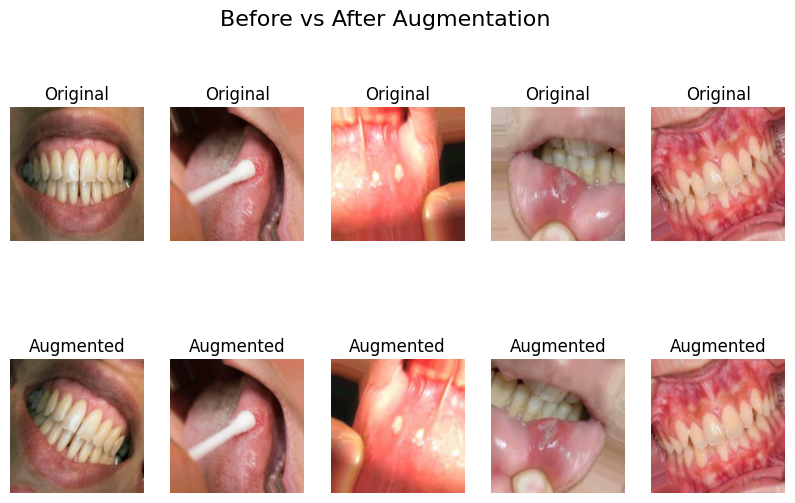

In [39]:
# ==============================
# STEP 3: Data Augmentation + Show Before & After
# ==============================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

plt.figure(figsize=(10, 6))

for images, _ in train_ds.take(1):
    for i in range(5):
        # Original image
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        # Augmented image
        augmented_img = data_augmentation(images)[i]
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

plt.suptitle("Before vs After Augmentation", fontsize=16)
plt.show()


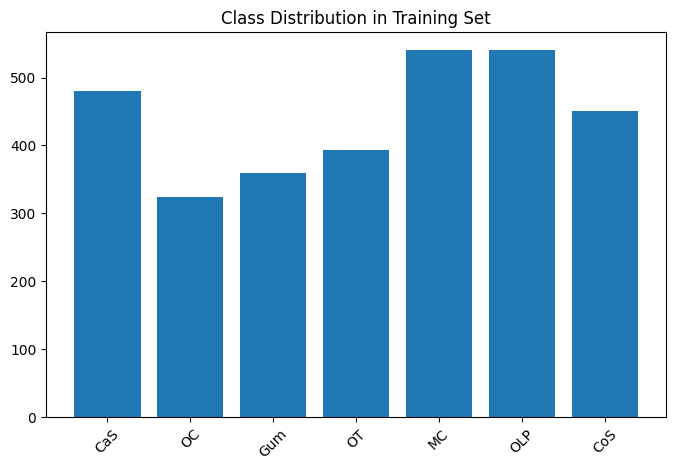

In [41]:

# ==============================
# STEP 4: Visualize Class Distribution
# ==============================
import matplotlib.pyplot as plt

def count_images_per_class(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images_per_class(train_dir)
plt.figure(figsize=(8,5))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()





In [42]:
# ==============================
# STEP 6: Build Pretrained Model (EfficientNetB0)
# ==============================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

inputs = keras.Input(shape=(img_size[0], img_size[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)
base_model.trainable = False  # Stage 1: freeze

x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_15[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [43]:
# ==============================
# STEP 7: Training (Stage 1: Frozen Base)
# ==============================
epochs_stage1 = 5
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_stage1
)



Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.3517 - loss: 1.6614 - val_accuracy: 0.6255 - val_loss: 1.0905
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.5893 - loss: 1.1090 - val_accuracy: 0.7111 - val_loss: 0.8851
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.6607 - loss: 0.9312 - val_accuracy: 0.7374 - val_loss: 0.7876
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.7078 - loss: 0.8381 - val_accuracy: 0.7558 - val_loss: 0.7259
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.7566 - loss: 0.7740 - val_accuracy: 0.7831 - val_loss: 0.6484


In [47]:
# ==============================
# STEP 8: Fine-tuning (Stage 2: Unfreeze base)
# ==============================
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

epochs_stage2 = 45
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_stage2
)



Epoch 1/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 77s 378ms/step - accuracy: 0.9036 - loss: 0.3481 - val_accuracy: 0.9387 - val_loss: 0.2520
Epoch 2/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - accuracy: 0.9105 - loss: 0.3264 - val_accuracy: 0.9446 - val_loss: 0.2301
Epoch 3/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - accuracy: 0.9274 - loss: 0.2930 - val_accuracy: 0.9533 - val_loss: 0.2094
Epoch 4/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step - accuracy: 0.9247 - loss: 0.2798 - val_accuracy: 0.9582 - val_loss: 0.1916
Epoch 5/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.9286 - loss: 0.2586 - val_accuracy: 0.9601 - val_loss: 0.1744
Epoch 6/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - accuracy: 0.9382 - loss: 0.2386 - val_accuracy: 0.9640 - val_loss: 0.1610
Epoch 7/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - accuracy: 0.9365 - loss: 0.2425 - val_accuracy: 0.9660 - val_loss: 0.1486
Epoch 8/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step - accuracy: 0.9409 - loss: 0.2221 - val_accu

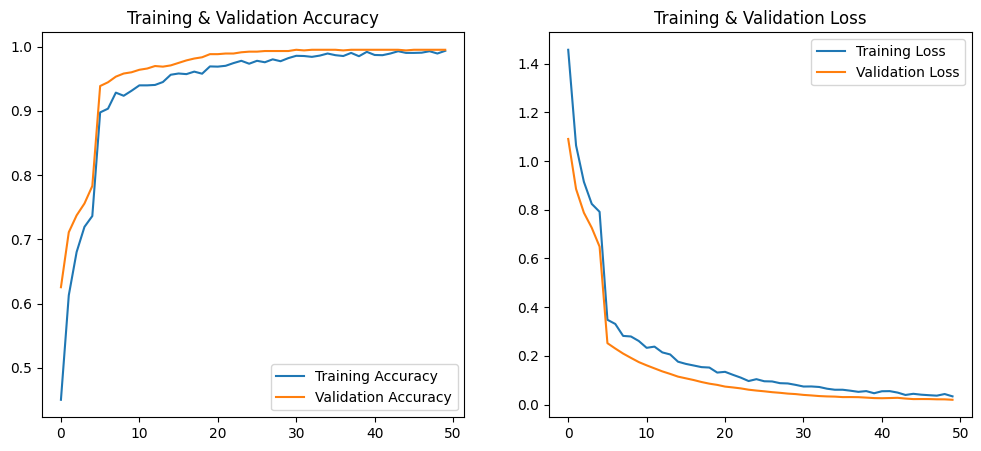

In [48]:
# ==============================
# STEP 9: Plot Accuracy and Loss
# ==============================
acc = history_stage1.history["accuracy"] + history_stage2.history["accuracy"]
val_acc = history_stage1.history["val_accuracy"] + history_stage2.history["val_accuracy"]
loss = history_stage1.history["loss"] + history_stage2.history["loss"]
val_loss = history_stage1.history["val_loss"] + history_stage2.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training & Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training & Validation Loss")

plt.show()



In [49]:
# ==============================
# STEP 10: Evaluate on Test Set
# ==============================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9974 - loss: 0.0153
✅ Test Accuracy: 0.9971


In [ ]:
model.save("teeth_model.h5")


In [ ]:
from google.colab import files
files.download("teeth_model.h5")


In [ ]:
!pip install streamlit pyngrok


In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load model
model = tf.keras.models.load_model("teeth_model.h5")

# Class names (adjust based on your dataset)
class_names = ["Cavity", "Healthy", "Implant"]

st.title("🦷 Teeth Classification App")
st.write("Upload a teeth image and the model will classify it.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    st.write(f"**Prediction:** {predicted_class}")
    st.write(f"**Confidence:** {confidence:.2f}")


In [ ]:
from pyngrok import ngrok

# Kill old tunnels
ngrok.kill()

# Run streamlit
!streamlit run streamlit_app.py &

# Get public URL
public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)
